In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import gc, time, warnings, joblib, pickle
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from itertools import combinations
from warnings import simplefilter

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)

warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

/kaggle/input/data1030-optiver-trading-at-close/xgboost_best_models.pkl
/kaggle/input/data1030-optiver-trading-at-close/test_dataset.pkl
/kaggle/input/data1030-optiver-trading-at-close/xgboost_scores.pkl
/kaggle/input/data1030-optiver-trading-at-close/train_val_dataset.pkl


In [2]:
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error

from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info,
)

In [3]:
# Load Data
data_folder = '/kaggle/input/data1030-optiver-trading-at-close/'
# data_folder = '../data/preprocessed/'

with open(os.path.join(data_folder, 'train_val_dataset.pkl'), 'rb') as file:
    train_val_dataset = pickle.load(file)
    
with open(os.path.join(data_folder, 'test_dataset.pkl'), 'rb') as file:
    test_dataset = pickle.load(file)

X_other, y_other, groups_other = train_val_dataset['X_other'], train_val_dataset['y_other'], train_val_dataset['groups_other']
X_test, y_test, groups_test, submission_id = test_dataset['X_test'], test_dataset['y_test'], test_dataset['groups_test'], test_dataset['submission_id']

# collect which encoder to use on each feature
onehot_ftrs = ['imbalance_buy_sell_flag', 'stock_id']
std_ftrs = ['seconds_in_bucket', 'imbalance_size', 'reference_price', 'matched_size', 
            'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 
            'wap', 'lagged_target_1d_0', 'lagged_target_1d_10', 'lagged_target_1d_20', 
            'lagged_target_1d_30', 'lagged_target_1d_40', 'lagged_target_1d_50', 
            'lagged_target_1d_60', 'lagged_target_1d_70', 'lagged_target_1d_80', 
            'lagged_target_1d_90', 'lagged_target_1d_100', 'lagged_target_1d_110', 
            'lagged_target_1d_120', 'lagged_target_1d_130', 'lagged_target_1d_140', 
            'lagged_target_1d_150', 'lagged_target_1d_160', 'lagged_target_1d_170', 
            'lagged_target_1d_180', 'lagged_target_1d_190', 'lagged_target_1d_200', 
            'lagged_target_1d_210', 'lagged_target_1d_220', 'lagged_target_1d_230', 
            'lagged_target_1d_240', 'lagged_target_1d_250', 'lagged_target_1d_260', 
            'lagged_target_1d_270', 'lagged_target_1d_280', 'lagged_target_1d_290', 
            'lagged_target_1d_300', 'lagged_target_1d_310', 'lagged_target_1d_320', 
            'lagged_target_1d_330', 'lagged_target_1d_340', 'lagged_target_1d_350', 
            'lagged_target_1d_360', 'lagged_target_1d_370', 'lagged_target_1d_380', 
            'lagged_target_1d_390', 'lagged_target_1d_400', 'lagged_target_1d_410', 
            'lagged_target_1d_420', 'lagged_target_1d_430', 'lagged_target_1d_440', 
            'lagged_target_1d_450', 'lagged_target_1d_460', 'lagged_target_1d_470', 
            'lagged_target_1d_480', 'lagged_target_1d_490', 'lagged_target_1d_500', 
            'lagged_target_1d_510', 'lagged_target_1d_520', 'lagged_target_1d_530', 
            'lagged_target_1d_540', 'volume', 'mid_price', 'liquidity_imbalance', 
            'matched_imbalance', 'size_imbalance', 'reference_price_far_price_imb', 
            'reference_price_near_price_imb', 'reference_price_ask_price_imb', 
            'reference_price_bid_price_imb', 'reference_price_wap_imb', 'far_price_near_price_imb', 
            'far_price_ask_price_imb', 'far_price_bid_price_imb', 'far_price_wap_imb', 
            'near_price_ask_price_imb', 'near_price_bid_price_imb', 'near_price_wap_imb', 
            'ask_price_bid_price_imb', 'ask_price_wap_imb', 'bid_price_wap_imb', 'price_spread', 
            'price_pressure', 'market_urgency', 'depth_pressure', 'all_prices_mean', 
            'all_sizes_mean', 'all_prices_std', 'all_sizes_std', 'all_prices_skew', 
            'all_sizes_skew', 'all_prices_kurt', 'all_sizes_kurt', 'dow', 'seconds', 'minute']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])

model_save_path = 'result' 
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

result_path = '/kaggle/working/result/'
# result_path = '../result/'

In [4]:
prep = Pipeline(steps=[('preprocessor', preprocessor)])

len_group_other = groups_other.nunique()
gts = GroupTimeSeriesSplit(test_size=int(len_group_other*0.25), n_splits=4)

for i_train, i_val in gts.split(X_other, y_other, groups_other):
    print("\t Train index:", i_train, "Val index:", i_val)
    print("\t Train size:", len(i_train), "Val size:", len(i_val))
    X_train, y_train, groups_train = X_other.iloc[i_train], y_other.iloc[i_train], groups_other.iloc[i_train]
    X_val, y_val, groups_val = X_other.iloc[i_val], y_other.iloc[i_val], groups_other.iloc[i_val]
    
    X_train_preprocessed = prep.fit_transform(X_train)
    feature_names = prep.get_feature_names_out()
    
    X_val_preprocessed = prep.transform(X_val)
    X_test_preprocessed = prep.transform(X_test)
    df_test = pd.DataFrame(data = X_test_preprocessed, columns = feature_names, index=y_test.index)

	 Train index: [     0      1      2 ... 743181 743182 743183] Val index: [ 743184  743185  743186 ... 1002231 1002232 1002233]
	 Train size: 743184 Val size: 259050
	 Train index: [ 10505  10506  10507 ... 753961 753962 753963] Val index: [ 753964  753965  753966 ... 1013066 1013067 1013068]
	 Train size: 743459 Val size: 259105
	 Train index: [ 21010  21011  21012 ... 764741 764742 764743] Val index: [ 764744  764745  764746 ... 1023901 1023902 1023903]
	 Train size: 743734 Val size: 259160
	 Train index: [ 31515  31516  31517 ... 775521 775522 775523] Val index: [ 775524  775525  775526 ... 1034736 1034737 1034738]
	 Train size: 744009 Val size: 259215


# XGBoost

In [5]:
with open(data_folder+'xgboost_best_models.pkl', 'rb') as file:
    best_models_xgb = pickle.load(file)

best_model_xgb = best_models_xgb[-1]
best_model_xgb.fit(X_train_preprocessed, y_train,
                   eval_set=[(X_val_preprocessed, y_val)],
                   early_stopping_rounds=50, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=6000, n_jobs=None, n_thread=-1,
             num_parallel_tree=None, ...)

In [6]:
from sklearn.inspection import permutation_importance

# columns can be highly correlated

# result = permutation_importance(best_model_xgb, df_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
# permutation_importance = pd.DataFrame({'feature_names': feature_names, 
#                                        'importance_mean': result.importances_mean,
#                                        'importance_std': result.importances_std})
# display(permutation_importance)

In [7]:
best_model_xgb.best_iteration

220

In [8]:
# Extract feature importances
# importance_weight = best_model_xgb.get_booster().get_score(importance_type='weight')
# importance_gain = best_model_xgb.get_booster().get_score(importance_type='gain')
# importance_cover = best_model_xgb.get_booster().get_score(importance_type='cover')
# importance_total_gain = best_model_xgb.get_booster().get_score(importance_type='total_gain')
# importance_total_cover = best_model_xgb.get_booster().get_score(importance_type='total_cover')

# # Convert to DataFrame for easy handling
# importances = pd.DataFrame({'weight': pd.Series(importance_weight, index=feature_names),
#                             'gain': pd.Series(importance_gain, index=feature_names),
#                             'cover': pd.Series(importance_cover, index=feature_names),
#                             'total_gain': pd.Series(importance_total_gain, index=feature_names),
#                             'total_cover': pd.Series(importance_total_cover, index=feature_names)})
# # display(importances)

In [9]:
import matplotlib.pyplot as plt

def plot_importance(importance_series, title):
    plt.figure(figsize=(5, 3))
    top_features = importance_series.sort_values(ascending=False).head(10)
    print(top_features.index)
    top_features.plot(kind='barh', color='r', alpha=0.4)
    plt.title(title)
    plt.show()

# Plot for each metric
# for metric in importances.columns:
#     plot_importance(importances[metric], f'Top 10 Important Features by {metric.title()}')

## XGB Gain

In [10]:
# gain
XGB = best_models_xgb[-1]
XGB.set_params(**{'importance_type':'gain'})
XGB.fit(X_train_preprocessed, y_train,
                   eval_set=[(X_val_preprocessed, y_val)],
                   early_stopping_rounds=50, verbose=False)
importances = XGB.feature_importances_
index_ = np.argsort(importances)

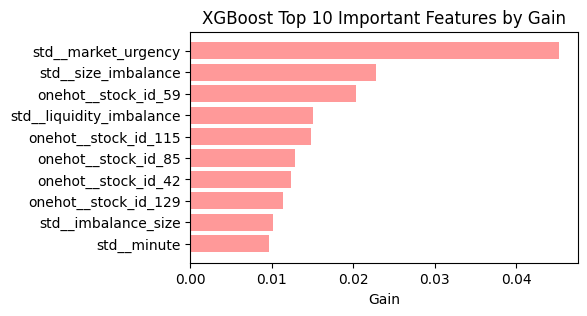

['onehot__stock_id_149' 'onehot__stock_id_163' 'onehot__stock_id_164'
 'onehot__stock_id_99' 'onehot__stock_id_167']


In [11]:
# absolute mean importance
importances[index_]

plt.figure(figsize=(5,3))
plt.barh(feature_names[index_[-10:]], importances[index_[-10:]], color='r', alpha=0.4)
plt.xlabel('Gain')
plt.title('XGBoost Top 10 Important Features by Gain')
plt.savefig('xgboost_importance_gain', bbox_inches='tight', dpi=300)
plt.show()

print(feature_names[index_[0:5]])

## XGB Weight

In [12]:
# gain
XGB = best_models_xgb[-1]
XGB.set_params(**{'importance_type':'weight'})
XGB.fit(X_train_preprocessed, y_train,
                   eval_set=[(X_val_preprocessed, y_val)],
                   early_stopping_rounds=50, verbose=False)
importances = XGB.feature_importances_
index_ = np.argsort(importances)

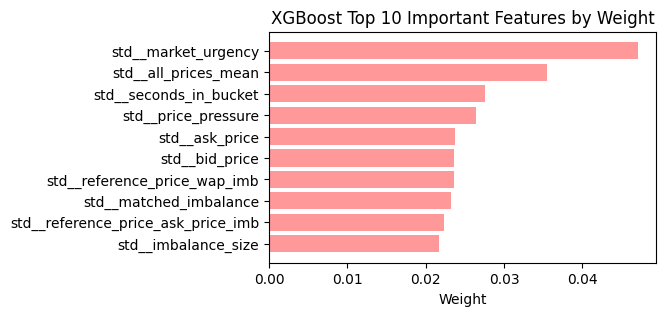

['onehot__stock_id_149' 'onehot__stock_id_99' 'onehot__stock_id_162'
 'onehot__stock_id_96' 'onehot__stock_id_95']


In [13]:
# absolute mean importance
importances[index_]

plt.figure(figsize=(5,3))
plt.barh(feature_names[index_[-10:]], importances[index_[-10:]], color='r', alpha=0.4)
plt.xlabel('Weight')
plt.title('XGBoost Top 10 Important Features by Weight')
plt.savefig('xgboost_importance_weight', bbox_inches='tight', dpi=300)
plt.show()

print(feature_names[index_[0:5]])

# SHAP

(260040, 300) (260040, 300)


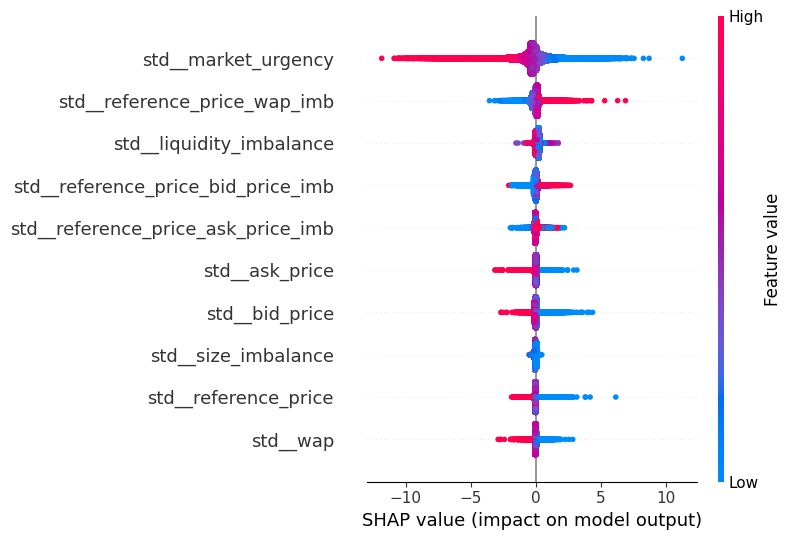

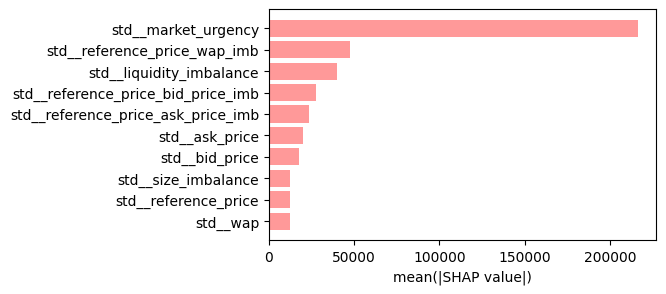

In [14]:
# your code here
import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer = shap.TreeExplainer(best_model_xgb)
# shap on test set
shap_values = explainer.shap_values(df_test)
print(np.shape(df_test), np.shape(shap_values))

# summary plot
shap.summary_plot(shap_values, df_test, feature_names = feature_names, max_display=10)

# absolute mean importance
shap_summary = np.sum(np.abs(shap_values), axis=0) # same shape as the number of features
indcs = np.argsort(shap_summary)
shap_summary[indcs]

plt.figure(figsize=(5,3))
plt.barh(feature_names[indcs[-10:]], shap_summary[indcs[-10:]], color='r', alpha=0.4)
plt.xlabel('mean(|SHAP value|)')
plt.show()

In [15]:
feature_names[indcs[:5]]

array(['onehot__stock_id_149', 'onehot__stock_id_99',
       'onehot__stock_id_163', 'onehot__stock_id_96',
       'onehot__stock_id_95'], dtype=object)

In [16]:
shap_summary[indcs[:10]]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [17]:
index = 2134
print('index:', index)
shap.force_plot(explainer.expected_value, shap_values[index, :], features = df_test.iloc[index,:], feature_names = feature_names)

index: 2134
